///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////                    

                                KRISSAAN AMEN ALLAH - M2 -TRIED                   

                                amenallahkrissane10@gmail.com                   

                            amen-allah.krissaan@telecom-sudparis.eu 
                            
                                        Lab 5- DEEP RN          

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# TP 5.1 - Modèles autoregressifs

**L’objectif de ce TP est d’utiliser des réseaux de neurones pour l'apprentissage de modèles autoregressifs.**

## Exercice 1 : Génération de poésie

Une première application va consister à apprendre à générer du texte. Nous allons partir d’une base de données d’un recueil de poésies, « les fleurs de mal » de Charles Baudelaire.
On pourra récupérer le fichier d’entrée à l’adresse suivante: [http://cedric.cnam.fr/~thomen/cours/US330X/fleurs_mal.txt](http://cedric.cnam.fr/~thomen/cours/US330X/fleurs_mal.txt).

In [19]:
%pip install requests


[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from requests import get  # to make GET request

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

In [21]:
download('http://cedric.cnam.fr/~thomen/cours/US330X/fleurs_mal.txt',"fleurs_mal.txt")

### **a) Génération des données et étiquettes**

On créera un script `exo0.py` pour générer les données et étiquettes. On va commencer par parser le ficher d’entrée pour récupérer le texte et effectuer quelques pré-traitements simples:

In [22]:
bStart = False
fin = open("fleurs_mal.txt", 'r' , encoding = 'utf8')
lines = fin.readlines()
lines2 = []
text = []

for line in lines:
    line = line.strip().lower() # Remove blanks and capitals
    if("Charles Baudelaire avait un ami".lower() in line and bStart==False):
        print("START")
        bStart = True
    if("End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower() in line):
        print("END")
        break

    if(bStart==False or len(line) == 0):
        continue

    lines2.append(line)

fin.close()
text = " ".join(lines2)
chars = sorted(set([c for c in text]))
nb_chars = len(chars)

START
END


### Question :
---
Comment s’interprète la variable `chars` ? Que représente `nb_chars` ?

La variable `chars` est une liste triée des caractères uniques présents dans le texte. Elle représente le dictionnaire de symboles utilisés dans le texte.

`nb_chars` est le nombre de caractères uniques dans ce dictionnaire. Il représente la taille du vocabulaire utilisé pour encoder les caractères en one-hot.

---
Dans la suite, on va considérer chaque caractère du texte d’entrée par un encodage *one-hot* sur le dictionnaire de symboles. **On va appliquer un réseau de neurones récurrent qui va traiter une séquence de SEQLEN caractères, et dont l’objectif va être de prédire le caractère suivant en fonction de la séquence courante.** On se situe donc dans le cas d’un problème d’apprentissage *auto-supervisé*, *i.e.* qui ne contient pas de label mais dont on va construire artificiellement une supervision.

Les données d’entraînement consisteront donc en un ensemble de séquences d’entraînement de taille SEQLEN, avec une étiquette cible correspondant au prochain caractère à prédire.

In [23]:
SEQLEN = 10 # Length of the sequence to predict next char
STEP = 1 # stride between two subsequent sequences
input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i:i+SEQLEN])
    label_chars.append(text[i+SEQLEN])
nbex = len(input_chars)

On va maintenant vectoriser les données d’entraînement en utilisant le dictionnaire et un encodage *one-hot* pour chaque caractère.

In [24]:
# mapping char -> index in dictionary: used for encoding (here)
char2index = dict((c, i) for i, c in enumerate(chars))
# mapping char -> index in dictionary: used for decoding, i.e. generation - part c)
index2char = dict((i, c) for i, c in enumerate(chars)) # mapping index -> char in dictionary

Chaque séquence d’entraînement est donc représentée par une matrice de taille $ SEQLEN \times tdict $, correspondant à une longueur de $ SEQLEN $ caractères, chaque caratère étant encodé par un vecteur binaire correspondant à un encodage *one-hot*.

- L’ensemble des données d’entraînement `X` seront donc constituées par un tenseur de taille $ nbex \times SEQLEN \times tdict $  
- L’ensemble des labels d’entraînement `y` seront représentées par un tenseur de $ nbex \times tdict $, où la sortie pour chaque exemple correspond à l’indice dans le dictionnaire du caractère suivant la séquence  

### Question :

Compléter le code suivant pour créer les données et labels d’entraînement. **N.B.** : utiliser la variable `char2index`.

In [25]:
import numpy as np
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=bool)
y = np.zeros((len(input_chars), nb_chars), dtype=bool)

In [26]:
#for i, input_char in enumerate(input_chars):
    #for j, ch in enumerate(input_char):
        # Votre code ici

for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
      # Fill X at correct
      s = char2index.get(ch)
      X[i, j, s] = True
      s = char2index[label_chars[i]]
       # Fill y at correct index
      y[i, s] = True


On va maintenant séparer les données en deux ensembles d’apprentissage et de test, et les sauvegarder

In [27]:
import _pickle as pickle

ratio_train = 0.8
nb_train = int(round(len(input_chars)*ratio_train))
print("nb tot=",len(input_chars) , "nb_train=",nb_train)
X_train = X[0:nb_train,:,:]
y_train = y[0:nb_train,:]

X_test = X[nb_train:,:,:]
y_test = y[nb_train:,:]
print("X train.shape=",X_train.shape)
print("y train.shape=",y_train.shape)

print("X test.shape=",X_test.shape)
print("y test.shape=",y_test.shape)

outfile = "Baudelaire_len_"+str(SEQLEN)+".p"

with open(outfile, "wb" ) as pickle_f:
    pickle.dump( [index2char, X_train, y_train, X_test, y_test], pickle_f)

nb tot= 146166 nb_train= 116933
X train.shape= (116933, 10, 60)
y train.shape= (116933, 60)
X test.shape= (29233, 10, 60)
y test.shape= (29233, 60)


### **b) Apprentissage d’un modèle auto-supervisé pour la génération de texte**

On va maintenant entraîner un réseau de neurone récurrent. On va commencer par charger les données précédentes :

In [28]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )

Puis créer un modèle séquentiel :

In [29]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, RMSprop

model = Sequential()

Puis on va ajouter une couche récurrente avec un modèle de type `SimpleRNN` :

In [30]:
HSIZE = 128
model.add(SimpleRNN(HSIZE, return_sequences=False, input_shape=(SEQLEN, nb_chars),unroll=True))

c:\Users\amena\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Question :
---
- Expliquer à quoi correspond `return_sequences=False`. **N.B.** : `unroll=True` permettra simplement d’accélérer les calculs.  


1. **`return_sequences=False`** :
   - Le RNN ne retourne que la **sortie finale** de la séquence (dernier pas de temps).
   - Utile pour prédire une seule valeur à la fin (ex : prochain caractère).

2. **`unroll=True`** :
   - Accélère les calculs en "déroulant" la boucle récurrente.
   - Consomme plus de mémoire, mais efficace pour des séquences courtes.

En résumé :
- `return_sequences=False` : Sortie finale uniquement.
- `unroll=True` : Optimisation pour accélérer les calculs.


---
On ajoutera enfin une couche complètement connectée suivie d’une fonction `softmax` for effectuer la classification du caractère suivant la séquence.

In [31]:
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

Pour optimiser des réseaux récurrents, on utilise préférentiellement des méthodes adaptatives comme `RMSprop` [[TH12]](#tieleman2012). On pourra donc compiler le modèle et utiliser la méthode `summary()` pour visualiser le nombre de paramètres du réseaux

In [32]:
BATCH_SIZE = 128
NUM_EPOCHS = 50
learning_rate = 0.001

optim = RMSprop(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        24,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,932 (124.73 KB)

 Trainable params: 31,932 (124.73 KB)

 Non-trainable params: 0 (0.00 B)

L’entraînement sera effectuer comme habituellement avec la méthode `fit()`:

In [33]:
# FIT MODEL TO DATA
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)
# EVALUATE TRAINED MODEL
scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_test, y_test, verbose=1)
print("PERFS TRAIN: %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))

Epoch 1/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2505 - loss: 2.6939
Epoch 2/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3423 - loss: 2.1974
Epoch 3/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3621 - loss: 2.1147
Epoch 4/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3762 - loss: 2.0525
Epoch 5/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3890 - loss: 2.0127
Epoch 6/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4026 - loss: 1.9606
Epoch 7/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4159 - loss: 1.9248
Epoch 8/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4247 - loss: 1.8947
Epoch 9/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4339 - loss: 1.8586
Epoch 10/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4414 - loss: 1.8292
Epoch 11/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4448 - loss: 1.8046
Epoch 12/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

On pourra utiliser la méthode `saveModel` pour stocker le modèle appris :

In [41]:
from keras.models import model_from_json

def saveModel(model, savename):
    # serialize model to JSON
    model_json = model.to_json()
    with open(savename+".json", "w") as json_file:
        json_file.write(model_json)
        print("JSON Model ",savename,".json saved to disk")
    # serialize weights to HDF5
    model.save_weights(savename+".h5")
    print("Weights ",savename,".h5 saved to disk")

In [43]:
nameModel = "RNN_"+str(HSIZE)+ "_"+ str(NUM_EPOCHS)+"_It.weights"
saveModel(model, nameModel)

JSON Model  RNN_128_50_It.weights .json saved to disk
Weights  RNN_128_50_It.weights .h5 saved to disk


### Analyse de l’apprentissage

Quelles taux de classification obtient-on en apprentissage ? Commenter les performances obtenues. En quoi le problème est-il différents des problèmes de classification abordés jusqu’ici ? Par exemple, faire une recherche de la séquence d’entrée « la mort de », et analyser les labels cibles présents dans le corpus d’apprentissage.


<a id='text-gen'></a>

---
### Taux de classification :
- **Entraînement : 53.57%**
- **Test : 45.94%**

### Commentaire :
- Faible précision : Le modèle apprend mal et généralise peu.
- **Surapprentissage** : Écart entre entraînement et test.

### Différence avec la classification classique :
1. **Données séquentielles** : Chaque caractère dépend des précédents.
2. **Contexte variable** : Un même caractère a des sens différents selon le contexte.
3. **Granularité fine** : Prédire un caractère est plus difficile qu'une classe entière.

### Analyse de « la mort de » :
- **Contexte varié** : Suivi de différents caractères (ex : 'l', 'a', 'h').
- **Prédiction difficile** : Le même contexte peut mener à plusieurs caractères.

### Conclusion :
- Performances faibles à cause de la complexité du texte.
- Solutions : Utiliser des LSTM/GRU, augmenter la taille du réseau ou du corpus.
- La prédiction de caractères est plus complexe que la classification classique.
- Le taux de classification en apprentissage dépend de la complexité du modèle et de la qualité des données. Les performances peuvent être commentées en comparant les résultats sur les ensembles d'entraînement et de test.

- Ce problème diffère des problèmes de classification classiques car il s'agit d'un problème séquentiel où la prédiction d'un caractère dépend des caractères précédents. Par exemple, pour la séquence "la mort de", les labels cibles varient en fonction du contexte.

---

### **c) Génération de texte avec le modèle appris**

> On va maintenant se servir du modèle précédemment entraîné pour générer du texte qui va « imiter » le style du corpus de poésie sur lequel il a été appris.
On mettre en place un script `exo2.py` pour cette partie.

On va commencer par charger les données :

In [44]:
SEQLEN = 10
outfile = "Baudelaire_len_"+str(SEQLEN)+".p"
[index2char, X_train, y_train, X_test, y_test] = pickle.load( open( outfile, "rb" ) )

Et le réseau récurrent avec la fonction `loadModel` :

In [45]:
from keras.models import model_from_json
def loadModel(savename):
    with open(savename+".yaml", "r") as yaml_file:
        model = model_from_json(yaml_file.read())
    print("Yaml Model ",savename,".yaml loaded ")
    model.load_weights(savename+".h5")
    print("Weights ",savename,".h5 loaded ")
    return model

On pourra vérifier l’architecture du réseau avec la méthode `summary`, et évaluer les performances :

In [47]:
from keras.models import model_from_json

def loadModel(savename):
	with open(savename + ".json", "r") as json_file:
		model = model_from_json(json_file.read())
	print("JSON Model ", savename, ".json loaded ")
	model.load_weights(savename + ".h5")
	print("Weights ", savename, ".h5 loaded ")
	return model

nameModel = "RNN_" + str(HSIZE) + "_" + str(NUM_EPOCHS) + "_It.weights"
model = loadModel(nameModel)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
nb_chars = len(index2char)

JSON Model  RNN_128_50_It.weights .json loaded 
Weights  RNN_128_50_It.weights .h5 loaded 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        24,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 60)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,932 (124.73 KB)

 Trainable params: 31,932 (124.73 KB)

 Non-trainable params: 0 (0.00 B)

On va maintenant sélectionner une chaîne de caractère initiale pour notre réseau, afin de prédire le caractère suivant :

In [48]:
seed =15608
char_init = ""
for i in range(SEQLEN):
    char = index2char[np.argmax(X_train[seed,i,:])]
    char_init += char

print("CHAR INIT: "+char_init)

CHAR INIT: souvent, p


On va convertir la séquence de départ au format *one-hot* pour appliquer le modèle de prédiction.

In [49]:
test = np.zeros((1, SEQLEN, nb_chars), dtype=bool)
test[0,:,:] = X_train[seed,:,:]

Au lieu de prédire directement la sortie de probabilité maximale, on va échantillonner une sortie tirée selon la distribution de probabilités du soft-max.
Pour commencer on va utiliser un paramètre de température pour rendre la distribution plus ou moins piquée. On va transformer la distribution en sortie du soft-max de la façon suivante :


<a id='equation-normalisation-temperature'></a>
$$
z_{i}^N  = \frac{z_{i}^{\frac{1}{T}}}{\sum\limits_{j=1}^C z_{j}^{\frac{1}{T}} } \tag{1}
$$

On pourra utiliser la fonction suivante pour effectuer l’échantillonage après transformation de distribution:

In [50]:
def sampling(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    predsN = pow(preds,1.0/temperature)
    predsN /= np.sum(predsN)
    probas = np.random.multinomial(1, predsN, 1)
    return np.argmax(probas)

La figure ci-dessous montre l’impact sur la distribution de cette renormalisation :

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/temperature.png" style="height:280px;" align="center">

### Questions
---
- Quel va être le comportement de cet échantillonnage lorsque la température T augmente ($ T \rightarrow +\infty $) ou diminue ($ T \rightarrow 0 $) ?  


### Comportement de l'échantillonnage avec \( T \) :

1. **$ T \rightarrow +\infty $** :
   - Distribution **uniforme**.
   - Prédictions **aléatoires**, diversifiées, mais peu cohérentes.

2. **$ T \rightarrow 0 $** :
   - Distribution **piquée**.
   - Prédictions **déterministes**, cohérentes, mais peu variées.



### Application :
- **\( T \) élevée** : Créativité, exploration.
- **\( T \) faible** : Précision, cohérence.

---


**On va maintenant mettre en place la génération de texte à partir d’une séquence de SEQLEN caractère initiaux.** Compléter le code suivant :

In [51]:
nbgen = 400 # number of characters to generate (1,nb_chars)
gen_char = char_init
temperature  = 0.5
#gen_char = ''

for i in range(nbgen):
    preds = model.predict(test)[0]  # shape (1,nb_chars)
    next_ind = sampling(preds, temperature)
    next_char = index2char[next_ind]
    gen_char += next_char
    # Votre code ici

    for i in range(SEQLEN-1):
        test[0,i,:] = test[0,i+1,:]
    test[0,SEQLEN-1,:] = 0
    test[0,SEQLEN-1,next_ind] = 1

print("Generated text: "+gen_char)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

### Analyse de la génération

Evaluer l’impact du paramètre de température dans la génération, ainsi que le nombre d’époques dans l’apprentissage. Commenter les points forts et points faibles du générateur.


---
### Impact de la température (\( T \)) :

1. **\( T >> 1 \)** :
   - **Comportement** : Prédictions aléatoires, diversifiées.
   - **Points forts** : Créativité.
   - **Points faibles** : Manque de cohérence.

2. **\( T << 1 \)** :
   - **Comportement** : Prédictions déterministes, cohérentes.
   - **Points forts** : Précision.
   - **Points faibles** : Répétition, manque de créativité.

3. **\( T = 1 \)** :
   - **Comportement** : Équilibre entre diversité et cohérence.

---

### Impact du nombre d'époques :

1. **Peu d'époques** :
   - **Points forts** : Temps d'entraînement réduit.
   - **Points faibles** : Texte peu cohérent.

2. **Beaucoup d'époques** :
   - **Points forts** : Texte cohérent et précis.
   - **Points faibles** : Risque de surapprentissage.

### Points forts du générateur :
- Flexibilité (ajustement de \( T \)).
- Apprentissage progressif.

### Points faibles du générateur :
- Incohérence à haute \( T \).
- Répétition à basse \( T \).
- Surapprentissage avec trop d'époques.


### Conclusion :
- Ajustez \( T \) et le nombre d'époques pour équilibrer créativité, cohérence et précision.
- La température influence la créativité et la cohérence du texte généré. Une température élevée peut produire des résultats plus variés mais moins cohérents, tandis qu'une température faible donne des résultats plus prévisibles.
- Le nombre d'époques d'apprentissage affecte la qualité du modèle. Un modèle sous-entraîné peut générer du texte peu cohérent, tandis qu'un modèle surentraîné peut reproduire trop fidèlement le texte d'entraînement.



<a id='tp4-embedding'></a>

---
---


## Exercice 2 : Exercice 2 : Embedding Vectoriel de texte


Dans cet exercice, nous allons explorer l’embedding vectoriel de texte Glove [PSM14] qui sera utilisé dans la TP suivant pour décrire chaque mot d’un corpus dans un objectif de légendage d’images.

On va utiliser la base d’image FlickR8k (http://nlp.cs.illinois.edu/HockenmaierGroup/8k-pictures.html), pour laquelle chaque image est associée à 5 légendes différentes qui décrivent son contenu en langage naturel.

On va commencer par télécharger le fichier qui contient les légendes de la base d’image Flickr 8k : http://cedric.cnam.fr/~thomen/cours/US330X/flickr_8k_train_dataset.txt. La base d’apprentissage contient 6000 images, ce qui correspond à 30000 légendes.

## a) Extraction des embedding Glove des légendes

On va créer un script exo3.py pour extraire les embedding vectoriaux Glove des légendes de la base Glove. On utilisera le code suivant pour récupérer l’ensemble des mots présents :

In [71]:
import pandas as pd

filename = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\flickr_8k_train_dataset.txt'

# Ensure the file exists and is properly formatted
try:
	df = pd.read_csv(filename, delimiter='\t', header=None, names=['image', 'caption'])
except FileNotFoundError:
	print(f"File {filename} not found.")
	df = pd.DataFrame(columns=['image', 'caption'])

nb_samples = df.shape[0]
iter = df.iterrows()
allwords = []

for i in range(nb_samples):
	x = iter.__next__()
	cap_words = x[1]['caption'].split()  # split caption into words
	cap_wordsl = [w.lower() for w in cap_words]  # remove capital letters
	allwords.extend(cap_wordsl)

unique = list(set(allwords))  # List of different words in captions
print(len(unique))

7708


In [74]:
GLOVE_MODEL = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\glove.6B.100d.txt'
fglove = open(GLOVE_MODEL, "r")

On déterminer la liste des mots présents dans les légendes et dans le fichier Glove. Compléter le code suivant :

In [79]:
import numpy as np

# Ensure the file exists and is properly formatted
try:
    fglove = open(GLOVE_MODEL, "r", encoding='utf-8')
except FileNotFoundError:
    print(f"File {GLOVE_MODEL} not found.")
    fglove = None

if fglove:
    cpt = 0
    listwords = []
    listembeddings = []
    for line in fglove:
        row = line.strip().split()
        word = row[0]
        embedding = np.array(row[1:], dtype="float32")
        if word in unique or word == 'unk':
            listwords.append(word)
            listembeddings.append(embedding)
            cpt += 1
            print("word: " + word + " embedded " + str(cpt))

    fglove.close()
    nbwords = len(listembeddings)
    tembedding = len(listembeddings[0])
    print("Number of words=" + str(len(listembeddings)) + " Embedding size=" + str(tembedding))

word: the embedded 1
word: , embedded 2
word: . embedded 3
word: of embedded 4
word: to embedded 5
word: and embedded 6
word: in embedded 7
word: a embedded 8
word: " embedded 9
word: 's embedded 10
word: for embedded 11
word: - embedded 12
word: that embedded 13
word: on embedded 14
word: is embedded 15
word: was embedded 16
word: with embedded 17
word: he embedded 18
word: as embedded 19
word: it embedded 20
word: by embedded 21
word: at embedded 22
word: ( embedded 23
word: ) embedded 24
word: from embedded 25
word: his embedded 26
word: an embedded 27
word: be embedded 28
word: has embedded 29
word: are embedded 30
word: have embedded 31
word: but embedded 32
word: were embedded 33
word: not embedded 34
word: this embedded 35
word: who embedded 36
word: they embedded 37
word: had embedded 38
word: i embedded 39
word: which embedded 40
word: will embedded 41
word: their embedded 42
word: : embedded 43
word: or embedded 44
word: its embedded 45
word: one embedded 46
word: after embed

N.B. : on a ajouté le mot “unk” qui est destiné à coder les mots des légendes absents du fichiers d’embedding.

On va finalement créer la matrice des embedding, en ajoutant deux mots pour coder les mots “<start>” et “<end>” (utile pour le TP suivant) :

In [86]:
embeddings = np.zeros((len(listembeddings) + 2, tembedding))
for i in range(nbwords):
	embeddings[i, 0:tembedding] = listembeddings[i]

# Append <start> symbol
listwords.append('<start>')
embeddings[len(listembeddings), :] = np.zeros(tembedding)
embeddings[len(listembeddings), -2] = 1

# Append <end> symbol
listwords.append('<end>')
embeddings[len(listembeddings) + 1, :] = np.zeros(tembedding)
embeddings[len(listembeddings) + 1, -1] = 1

Expliquer la taille et le contenu de la matrice embeddings

- La matrice embeddings a une taille de (nombre de mots uniques + 2) × (taille de l'embedding + 2).

- Elle contient les vecteurs d'embedding Glove pour chaque mot, ainsi que deux vecteurs supplémentaires pour les symboles <start> et <end>.

Et sauvegarder la liste des mots et les vecteurs associés :



In [87]:
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
with open(outfile, "wb" ) as pickle_f:
    pickle.dump( [listwords, embeddings], pickle_f)

## b) Analyse des embedding Glove des légendes

On va commencer par ouvrir le fichier des embeddings, puis à normaliser les vecteurs pour qu’ils aient une norme euclidienne unité :

In [88]:
import numpy as np
import _pickle as pickle

outfile = 'Caption_Embeddings.p'
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
print("embeddings: " + str(embeddings.shape))

# l2 NORMALIZATION
for i in range(embeddings.shape[0]):
    embeddings[i] = embeddings[i] / np.linalg.norm(embeddings[i])

print("Normalized embeddings: " + str(embeddings.shape))

embeddings: (7004, 100)
Normalized embeddings: (7004, 100)


Expliquer l’objectif de la normalisation 

- La normalisation des vecteurs d'embedding permet de les ramener à une norme unité, ce qui facilite les calculs de similarité et de distance entre les vecteurs.

On va maintenant effectuer un clustering dans l’espace des embeddings en 10 groupes avec l’algorithme du KMeans : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. On utilisera max_iter=1000 et init=”random”.

In [89]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=1000, init='random')
kmeans.fit(embeddings)
clustersID = kmeans.labels_
clusters = kmeans.cluster_centers_

Afin d’afficher les points le point le plus proche de chaque centre, ainsi que les 20 points suivants les plus proche du centre, on pourra utiliser le code suivant :

In [90]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

pointsclusters = np.zeros((10, 2))  # Initialize with zeros, 10 clusters, 2D points
indclusters = np.zeros((10, len(embeddings)), dtype=int)  # Initialize with zeros, 10 clusters, indices of embeddings

for i in range(10):
    norm = np.linalg.norm((clusters[i] - embeddings), axis=1)
    inorms = np.argsort(norm)
    indclusters[i][:] = inorms[:]

    print("Cluster " + str(i) + " =" + listwords[indclusters[i][0]])
    for j in range(1, 21):
        print(" mot: " + listwords[indclusters[i][j]])

Cluster 0 =bike
 mot: bicycle
 mot: ride
 mot: bikes
 mot: boat
 mot: racers
 mot: riding
 mot: motorcycle
 mot: rides
 mot: riders
 mot: skis
 mot: bicycles
 mot: wheel
 mot: car
 mot: sailing
 mot: horseback
 mot: sled
 mot: racing
 mot: boats
 mot: racer
 mot: vehicle
Cluster 1 =walls
 mot: beneath
 mot: overlooking
 mot: courtyard
 mot: surrounded
 mot: hillside
 mot: nearby
 mot: roof
 mot: entrance
 mot: underneath
 mot: buildings
 mot: area
 mot: brick
 mot: near
 mot: along
 mot: beside
 mot: floors
 mot: walled
 mot: surrounding
 mot: sand
 mot: covered
Cluster 2 =game
 mot: second
 mot: play
 mot: first
 mot: third
 mot: team
 mot: player
 mot: straight
 mot: games
 mot: back
 mot: played
 mot: fourth
 mot: players
 mot: four
 mot: starting
 mot: winning
 mot: last
 mot: one
 mot: five
 mot: three
 mot: time
Cluster 3 =plastic
 mot: bags
 mot: bag
 mot: filled
 mot: boxes
 mot: cans
 mot: bottle
 mot: hand
 mot: glass
 mot: soft
 mot: cream
 mot: pieces
 mot: filling
 mot: bo

Montrer le résultat des centre du clustering obtenu ainsi que les plus proches de chaque centre. Commenter le résultat par rapport à la sémantique des mots.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7004 samples in 0.002s...
[t-SNE] Computed neighbors for 7004 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7004
[t-SNE] Computed conditional probabilities for sample 2000 / 7004
[t-SNE] Computed conditional probabilities for sample 3000 / 7004
[t-SNE] Computed conditional probabilities for sample 4000 / 7004
[t-SNE] Computed conditional probabilities for sample 5000 / 7004
[t-SNE] Computed conditional probabilities for sample 6000 / 7004
[t-SNE] Computed conditional probabilities for sample 7000 / 7004
[t-SNE] Computed conditional probabilities for sample 7004 / 7004
[t-SNE] Mean sigma: 0.313324
[t-SNE] Computed conditional probabilities in 0.177s
[t-SNE] Iteration 50: error = 201.0293579, gradient norm = 0.0000000 (50 iterations in 0.976s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 201.029358
[t-SNE] Iteration 10

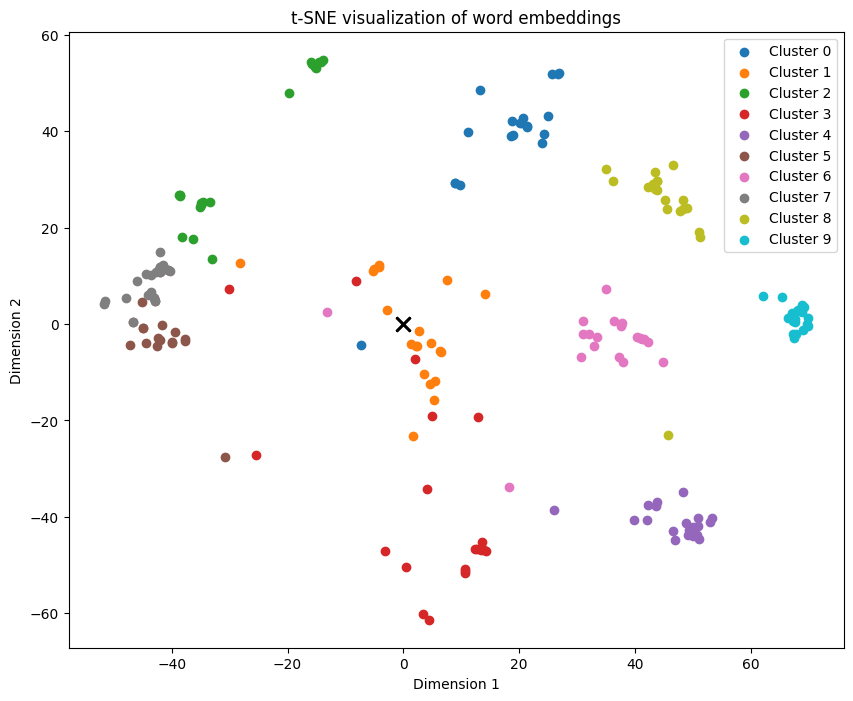

In [96]:
import matplotlib.pyplot as plt

# Ensure points2D is defined
tsne = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', early_exaggeration=24)
points2D = tsne.fit_transform(embeddings)

pointsclusters = np.zeros((10, 2))  # Initialize with zeros, 10 clusters, 2D points
indclusters = np.zeros((10, len(embeddings)), dtype=int)  # Initialize with zeros, 10 clusters, indices of embeddings

for i in range(10):
    norm = np.linalg.norm((clusters[i] - embeddings), axis=1)
    inorms = np.argsort(norm)
    indclusters[i][:] = inorms[:]

    print("Cluster " + str(i) + " =" + listwords[indclusters[i][0]])
    for j in range(1, 21):
        print(" mot: " + listwords[indclusters[i][j]])

plt.figure(figsize=(10, 8))
for i in range(10):
    cluster_points = points2D[indclusters[i][:20], :]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
    plt.scatter(pointsclusters[i, 0], pointsclusters[i, 1], c='black', marker='x', s=100)
plt.title('t-SNE visualization of word embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

Pour visualiser la répartition des points dans l’espace d’embedding, on pourra utiliser la méthode t-SNE:

In [97]:
tsne = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', early_exaggeration=24)
points2D = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7004 samples in 0.001s...
[t-SNE] Computed neighbors for 7004 samples in 0.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7004
[t-SNE] Computed conditional probabilities for sample 2000 / 7004
[t-SNE] Computed conditional probabilities for sample 3000 / 7004
[t-SNE] Computed conditional probabilities for sample 4000 / 7004
[t-SNE] Computed conditional probabilities for sample 5000 / 7004
[t-SNE] Computed conditional probabilities for sample 6000 / 7004
[t-SNE] Computed conditional probabilities for sample 7000 / 7004
[t-SNE] Computed conditional probabilities for sample 7004 / 7004
[t-SNE] Mean sigma: 0.313324
[t-SNE] Computed conditional probabilities in 0.153s
[t-SNE] Iteration 50: error = 201.0293579, gradient norm = 0.0000000 (50 iterations in 0.962s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 201.029358
[t-SNE] Iteration 10

C:\Users\amena\AppData\Local\Temp\ipykernel_41036\1581106517.py:9: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10),marker = '+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)


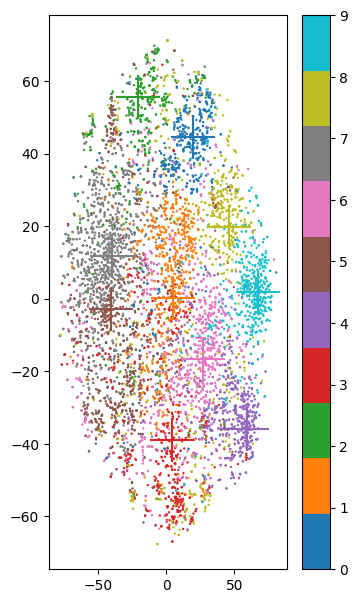

In [98]:
for i in range(10):
 pointsclusters[i,:] = points2D[int(indclusters[i][0])]

cmap =cm.tab10
plt.figure(figsize=(3.841, 7.195), dpi=100)
plt.set_cmap(cmap)
plt.subplots_adjust(hspace=0.4 )
plt.scatter(points2D[:,0], points2D[:,1], c=clustersID,  s=3,edgecolors='none', cmap=cmap, alpha=1.0)
plt.scatter(pointsclusters[:,0], pointsclusters[:,1], c=range(10),marker = '+', s=1000, edgecolors='none', cmap=cmap, alpha=1.0)

plt.colorbar(ticks=range(10))
plt.show()

- Les centres des clusters et les mots les plus proches de chaque centre peuvent être affichés pour analyser la sémantique des mots regroupés.

- La visualisation t-SNE permet de représenter les embeddings en 2D pour mieux comprendre la répartition des mots dans l'espace vectoriel.

---
---

# TP 5.2 - Vision et Langage 

Dans ce TP, nous abordons le problème du légendage d’images (« image captioning »), qui consiste à décrire le contenu visuel d’une image par une phrase en language naturel. Nous allons mettre en place une version simplifié de l’approche « show and tell » [VTBE15].

Le modèle va analyser une image en entrée, et à partir d’un symbole de début de séquence (“<start>”), va apprendre à générer le mot suivant de la légende. D’une manière générale, à partit d’un sous-ensemble de mot de la phrase généré et l’image d’entrée, l’objectif va être d’apprendre au modèle à générer le mot suivant, jusqu’à arriver au symbole de fin de génération (“<end>”).

# Exercice 1 : Simplification du vocabulaire

Pour accélérer le temps nécessaire à l’entraînement du modèle, nous allons considérer un sous-ensemble du vocabulaire de mots considéré au TP précédent (voir Exercice 2 : Embedding Vectoriel de texte). On pourra utiliser le code suivant pour extraire un histogramme d’occurrence des mots présents dans les légendes du sous-ensemble d’apprentissage de la base Flickr8k :

C:\Users\amena\AppData\Local\Temp\ipykernel_2508\3766955257.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cap_words = x[1][1].split()  # Split caption into words


Number of kept words=1000 - ratio=94.2358763006284 %


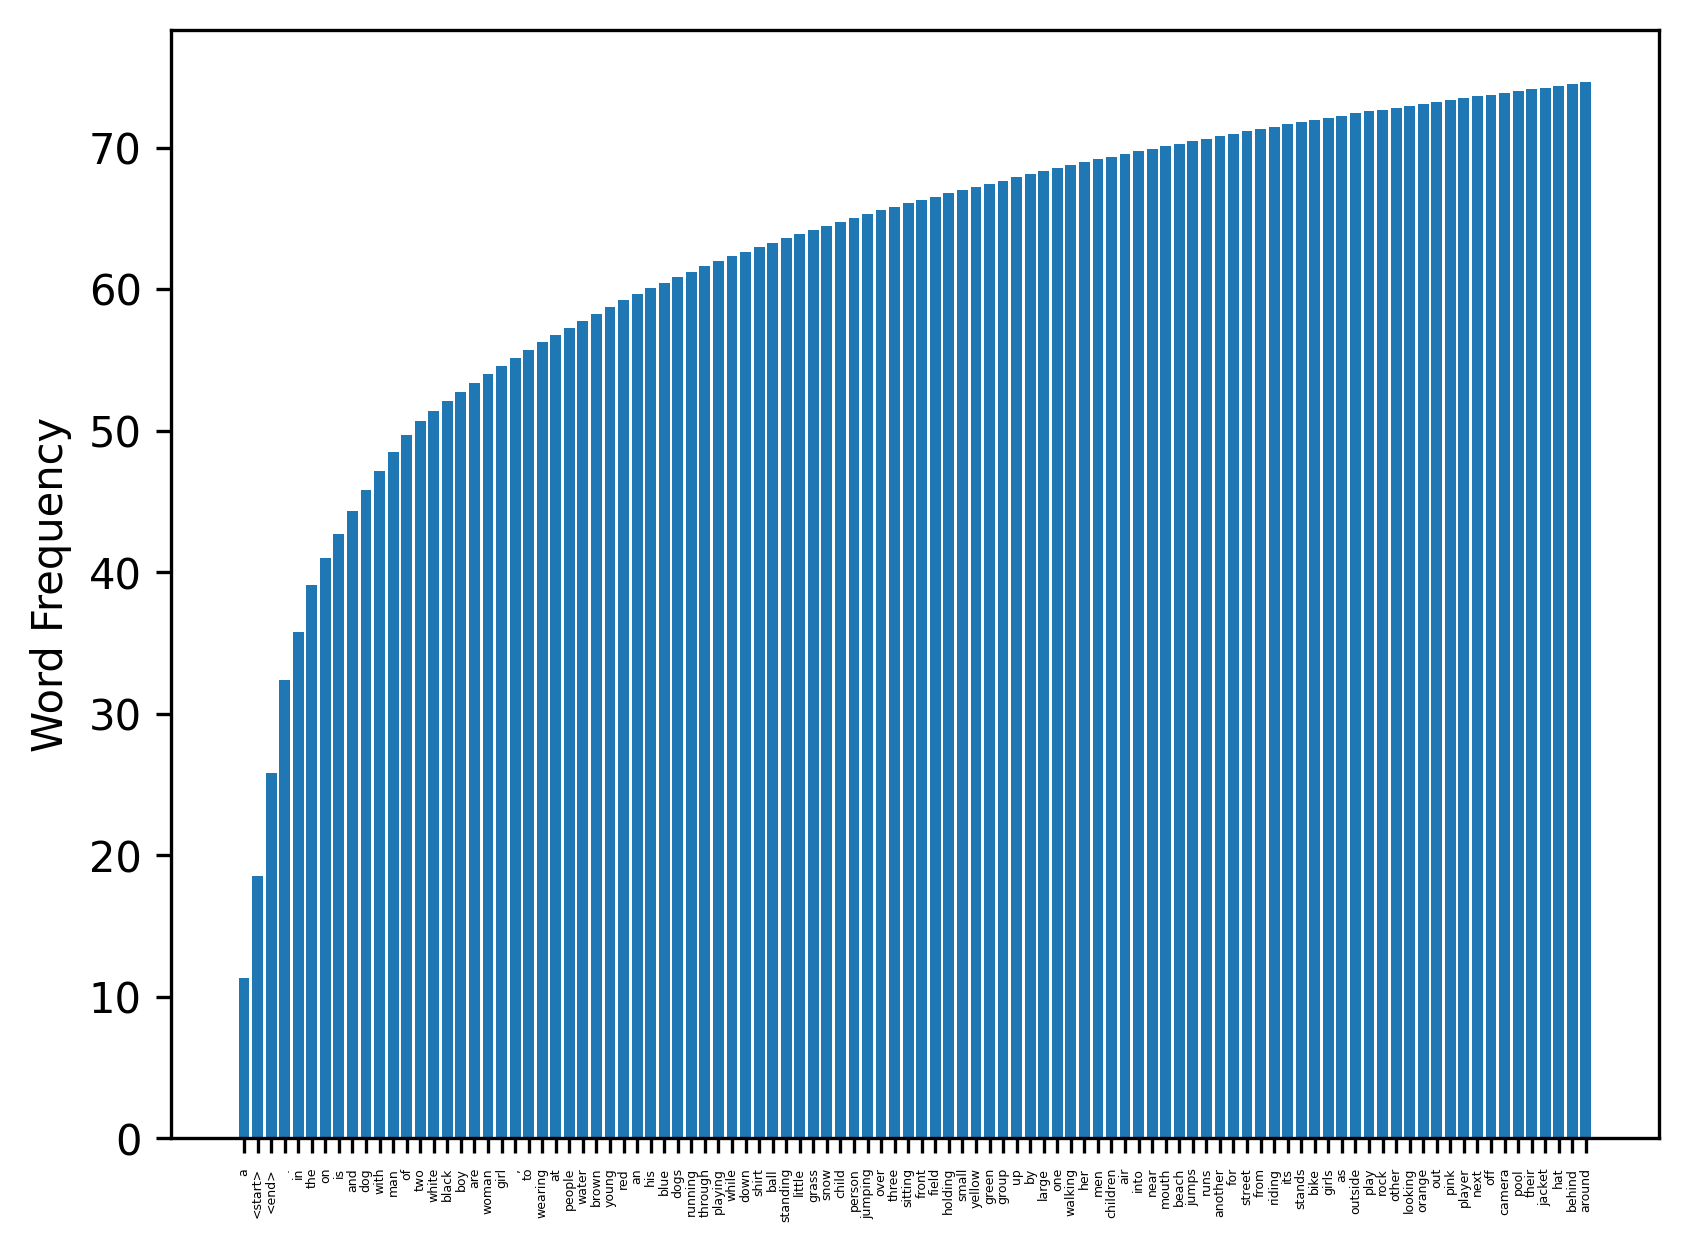

In [1]:
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
filename = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\flickr_8k_train_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nb_samples = df.shape[0]
iter = df.iterrows()

# Build a bag of words (bow)
bow = {}
nbwords = 0

for i in range(nb_samples):
    x = iter.__next__()
    cap_words = x[1][1].split()  # Split caption into words
    cap_wordsl = [w.lower() for w in cap_words]  # Remove capital letters
    nbwords += len(cap_wordsl)
    for w in cap_wordsl:
        if w in bow:
            bow[w] += 1
        else:
            bow[w] = 1

# Sort words by frequency
bown = sorted([(value, key) for (key, value) in bow.items()], reverse=True)

# Calculate cumulative frequency of the top 1000 words
nbkeep = 1000  # Number of words to keep
freqnc = np.cumsum([float(w[0]) / nbwords * 100.0 for w in bown])
print("Number of kept words=" + str(nbkeep) + " - ratio=" + str(freqnc[nbkeep - 1]) + " %")

# Plot the top 100 words
x_axis = [str(bown[i][1]) for i in range(100)]
plt.figure(dpi=300)
plt.xticks(rotation=90, fontsize=3)
plt.ylabel('Word Frequency')
plt.bar(x_axis, freqnc[0:100])
plt.show()

In [2]:
# Load embeddings and keep only the top `nbkeep` words
outfile = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\Caption_Embeddings.p'
[listwords, embeddings] = pickle.load(open(outfile, "rb"))

embeddings_new = np.zeros((nbkeep, 102))
listwords_new = []

for i in range(nbkeep):
    listwords_new.append(bown[i][1])
    embeddings_new[i, :] = embeddings[listwords.index(bown[i][1])]
    embeddings_new[i, :] /= np.linalg.norm(embeddings_new[i, :])  # Normalization

# Save the reduced vocabulary and embeddings
listwords = listwords_new
embeddings = embeddings_new
outfile = "Caption_Embeddings_" + str(nbkeep) + ".p"
with open(outfile, "wb") as pickle_f:
    pickle.dump([listwords, embeddings], pickle_f)

In [3]:
# Load the dataset
filename = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\flickr_8k_train_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nbTrain = df.shape[0]
iter = df.iterrows()

caps = []  # Set of captions
imgs = []  # Set of images
for i in range(nbTrain):
    x = iter.__next__()
    caps.append(x[1][1])
    imgs.append(x[1][0])

# Determine the maximum caption length
maxLCap = 0
for caption in caps:
    l = 0
    words_in_caption = caption.split()
    for j in range(len(words_in_caption) - 1):
        current_w = words_in_caption[j].lower()
        if current_w in listwords:
            l += 1
    if l > maxLCap:
        maxLCap = l

print("Max caption length =" + str(maxLCap))

# Load reduced vocabulary and embeddings
outfile = "Caption_Embeddings_" + str(nbkeep) + ".p"
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
indexwords = {}  # Useful for tensor filling
for i in range(len(listwords)):
    indexwords[listwords[i]] = i


C:\Users\amena\AppData\Local\Temp\ipykernel_2508\3997674588.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  caps.append(x[1][1])
C:\Users\amena\AppData\Local\Temp\ipykernel_2508\3997674588.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imgs.append(x[1][0])


Max caption length =35


# Exercice 2: Création des données d’apprentissage et de test


In [4]:

# Load image features
encoded_images = pickle.load(open(r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\encoded_images_PCA.p', "rb"))

# Allocate data and labels tensors
tinput = 202
tVocabulary = len(listwords)
X_train = np.zeros((nbTrain, maxLCap, tinput))
Y_train = np.zeros((nbTrain, maxLCap, tVocabulary), bool)

# Fill tensors
for i in range(nbTrain):
    words_in_caption = caps[i].split()
    indseq = 0  # Current sequence index
    for j in range(len(words_in_caption) - 1):
        current_w = words_in_caption[j].lower()
        if current_w in listwords:
            X_train[i, indseq, 0:100] = encoded_images[imgs[i]]  # Image features
            X_train[i, indseq, 100:202] = embeddings[indexwords[current_w]]  # Word embedding

        next_w = words_in_caption[j + 1].lower()
        if next_w in listwords:
            index_pred = indexwords[next_w]
            Y_train[i, indseq, index_pred] = True
            indseq += 1  # Increment index if target label is in the reduced dictionary

# Save training data
outfile = 'Training_data_' + str(nbkeep)
np.savez(outfile, X_train=X_train, Y_train=Y_train)

# Exercice 3: Entraînement du modèle


In [5]:
from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(maxLCap, tinput)))
model.add(SimpleRNN(100, return_sequences=True, unroll=True))
model.add(Dense(tVocabulary, activation='softmax'))

# Compile the model
optim = Adam()
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])

# Train the model
batch_size = 10
model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1)

c:\Users\amena\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.1124 - loss: 4.0849
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.1371 - loss: 2.9472
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.1431 - loss: 2.7492
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.1460 - loss: 2.6497
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.1500 - loss: 2.5769
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1503 - loss: 2.5352
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.1530 - loss: 2.4911
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1534 - loss: 2.4532
Epoch 9/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.1548 - loss: 2.4292
Epoch 10/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1561 - loss: 2.4125


In [10]:
from keras.models import model_from_json

# Save the model
def saveModel(model, savename):
    model_json = model.to_json()
    with open(savename + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(savename + ".weights.h5")
    print("Model saved to disk")

saveModel(model, "./image_captioning_model")

# Load the model
def loadModel(savename):
    with open(savename + ".json", "r") as json_file:
        model = model_from_json(json_file.read())
    model.load_weights(savename + ".weights.h5")
    return model


Model saved to disk


In [11]:
from keras.models import model_from_json


model = loadModel("image_captioning_model")

# Load test data
outfile = 'Training_data_' + str(nbkeep) + '.npz'
npzfile = np.load(outfile)
X_test = npzfile['X_train']
Y_test = npzfile['Y_train']

# Generate captions for a random test image
ind = np.random.randint(X_test.shape[0])
pred = model.predict(X_test[ind:ind + 1, :, :])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


In [13]:
# Sampling function for word prediction
def sampling(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generate captions
nbGen = 5
temperature = 0.1
for s in range(nbGen):
    wordpreds = "Caption n° " + str(s + 1) + ": "
    indpred = sampling(pred[0, 0, :], temperature)
    wordpred = listwords[indpred]
    wordpreds += str(wordpred) + " "
    X_test[ind:ind + 1, 1, 100:202] = embeddings[indpred]
    cpt = 1
    while str(wordpred) != '<end>' and cpt < 30:
        pred = model.predict(X_test[ind:ind + 1, :, :])
        indpred = sampling(pred[0, cpt, :], temperature)
        wordpred = listwords[indpred]
        wordpreds += str(wordpred) + " "
        cpt += 1
        X_test[ind:ind + 1, cpt, 100:202] = embeddings[indpred]
    print(wordpreds)

# Compute BLEU score
references = []  # Ground truth captions
predictions = []  # Predicted captions
blue_scores = np.zeros(4)
weights = np.zeros((4, 4))
weights[0, 0] = 1
weights[1, 0] = 0.5
weights[1, 1] = 0.5
weights[2, 0] = 1.0 / 3.0
weights[2, 1] = 1.0 / 3.0
weights[2, 2] = 1.0 / 3.0
weights[3, :] = 1.0 / 4.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Caption n° 1: a man and woman in black and white dress . <end> 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [18]:
for i in range(4):
    blue_scores[i] = nltk.translate.bleu_score.corpus_bleu(references, predictions, weights=(weights[i, 0], weights[i, 1], weights[i, 2], weights[i, 3]))
    print("BLEU-" + str(i + 1) + " score: " + str(blue_scores[i]))

BLEU-1 score: 1.0
BLEU-2 score: 1.0
BLEU-3 score: 1.0
BLEU-4 score: 1.0


# Exercice 4 : Évaluation du modèle

Finalement, on va utiliser le réseau récurrent pour générer une légende sur une image de test, et analyser qualitativement le résultat. On peut télécharger la base d’images ici : http://cedric.cnam.fr/~thomen/cours/US330X/Flickr8k_Dataset.zip

N.B. : en test, on dispose uniquement d’une image, et le système va, à partir du symbole “<start>”, itérativement produire une séquence de mots jusqu’à générer le symbole de fin de séquence”<end>”

On va commencer par charger un modèle appris, les données de test et les embeddings vectoriels avec le dictionnaire réduit :

On va ensuite sélectionner une image parmi l’ensemble de test, l’afficher, ainsi qu’une légende issues des annotations.

image name=2774362575_7543b8bf19.jpg caption=<start> A black and brown dog rests head on lower steps of stairs . <end>


C:\Users\amena\AppData\Local\Temp\ipykernel_2508\1305230340.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imname = x[1][0]
C:\Users\amena\AppData\Local\Temp\ipykernel_2508\1305230340.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("image name=" + imname + " caption=" + x[1][1])


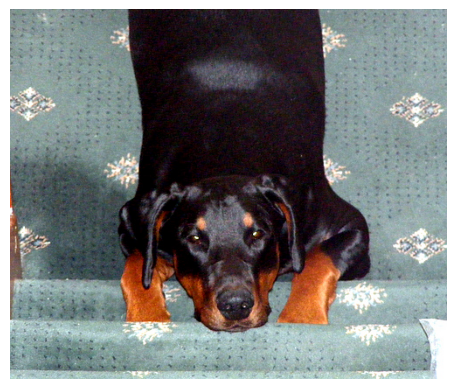

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle

ind = np.random.randint(X_test.shape[0])

filename = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\flickr_8k_train_dataset.txt'

df = pd.read_csv(filename, delimiter='\t')
iter = df.iterrows()

for i in range(ind+1):
	x = iter.__next__()

imname = x[1][0]
print("image name=" + imname + " caption=" + x[1][1])
dirIm = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\Flickr8k_Dataset\Flicker8k_Dataset'

img = mpimg.imread(os.path.join(dirIm, imname))
plt.figure(dpi=100)
plt.imshow(img)
plt.axis('off')
plt.show()

Pour effecteur la prédiction, on va partir du premier élément de la séquence (*i.e.* contenant l’image et le symbole “<start>”), et effectuer la prédiction :

In [35]:
pred = model.predict(X_test[ind:ind+1,:,:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


On va ensuite pouvoir effectuer plusieurs générations de légendes, en échantillonnant le mot de suivant à partir de la distribution *a posteriori* issue du softmax, comme ceci a été fait dans la partie c) Génération de texte avec le modèle appris du TP 5.1 - Réseaux de neurones récurrents (voir la fonction sampling). Une fois le mot suivant échantillonné, on place son embedding vectoriel comme entrée pour l’élément suivant de la séquence, et la prédiction continue (jusqu’à arriver au symbole de fin de séquence <”end”>). On pourra donc compléter le code suivant pour générer les légendes :

In [37]:
nbGen = 5
temperature=0.1 # Temperature param for peacking soft-max distribution

for s in range(nbGen):
 wordpreds = "Caption n° "+str(s+1)+": "
 indpred = sampling(pred[0,0,:], temperature)
 wordpred = listwords[indpred]
 wordpreds +=str(wordpred)+ " "
 X_test[ind:ind+1,1,100:202] = embeddings[indpred]
 cpt=1
 while(str(wordpred)!='<end>' and cpt<30):
  pred = model.predict(X_test[ind:ind+1,:,:])
  indpred = sampling(pred[0,cpt,:], temperature)
  wordpred = listwords[indpred]
  wordpreds += str(wordpred)+ " "
  cpt+=1
  X_test[ind:ind+1,cpt,100:202] = embeddings[indpred]

print(wordpreds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

Présentez des résultas de légendage sur différentes images. Vous pouvez tester avec un vocabulaire simplifié à 100 mots puis à 1000 mots. Voici quelques résultats obtenus avec un vocabulaire de taille 1000 :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Caption: a black and brown dog is running through a field . <end> 


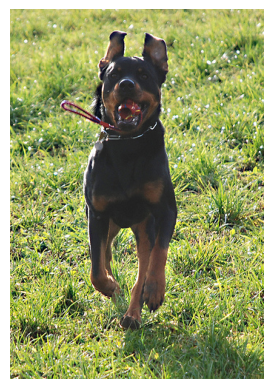

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Caption: a man is jumping into a pool . <end> 


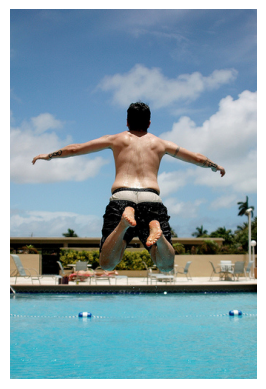

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Caption: a young girl is jumping into the air . <end> 


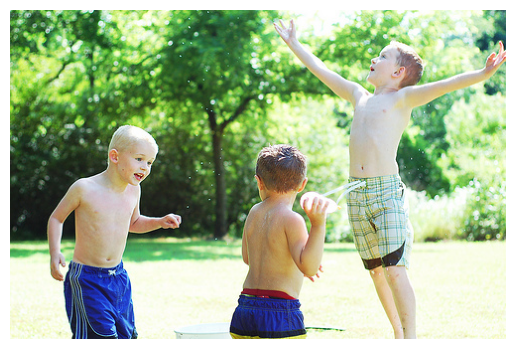

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Caption: a surfer is in a wave . <end> 


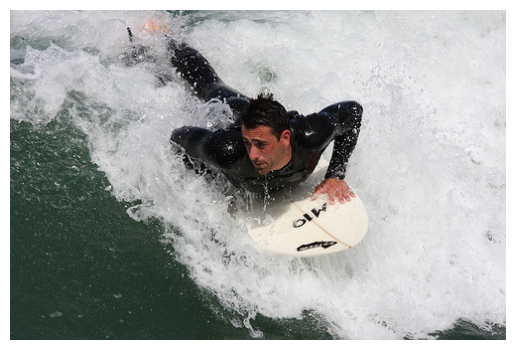

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Caption: a dog runs through the water . <end> 


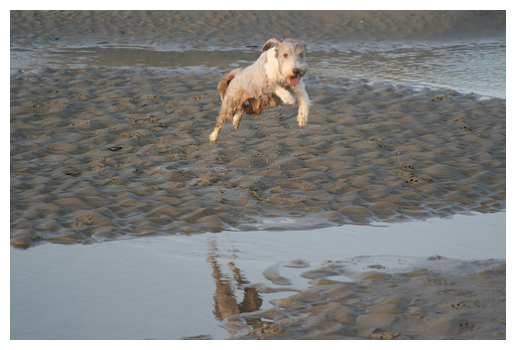

In [40]:
# Function to generate captions for a given image index
def generate_caption(model, X_test, index, listwords, embeddings, temperature=0.1, max_length=30):
    pred = model.predict(X_test[index:index+1, :, :])
    wordpreds = "Caption: "
    indpred = sampling(pred[0, 0, :], temperature)
    wordpred = listwords[indpred]
    wordpreds += str(wordpred) + " "
    X_test[index:index+1, 1, 100:202] = embeddings[indpred]
    cpt = 1
    while str(wordpred) != '<end>' and cpt < max_length:
        pred = model.predict(X_test[index:index+1, :, :])
        indpred = sampling(pred[0, cpt, :], temperature)
        wordpred = listwords[indpred]
        wordpreds += str(wordpred) + " "
        cpt += 1
        X_test[index:index+1, cpt, 100:202] = embeddings[indpred]
    return wordpreds

# Generate captions for random test images
num_images = 5
for _ in range(num_images):
    ind = np.random.randint(X_test.shape[0])
    caption = generate_caption(model, X_test, ind, listwords, embeddings, temperature=0.1)
    print(caption)
    
    # Display the image
    imname = imgs[ind]
    img_path = os.path.join(dirIm, imname)
    img = mpimg.imread(img_path)
    plt.figure(dpi=100)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [48]:
from keras.optimizers import RMSprop, Adam
from keras.models import model_from_json
import pandas as pd
import numpy as np
import nltk
import pickle

# LOADING TEST DATA
nbkeep = 1000
outfile = dirIm = r'B:\university\UNIVERSITY OF PARIS SACLAY\Master 2\SM 1\RN DEEP\TP\Flickr8k_Dataset\Flicker8k_Dataset'

# Load test data
outfile = 'Training_data_' + str(nbkeep) + '.npz'
npzfile = np.load(outfile)
X_test = npzfile['X_train']
Y_test = npzfile['Y_train']


model = loadModel("image_captioning_model")

# COMPILING MODEL
optim = Adam()
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])
scores_test = model.evaluate(X_test, Y_test, verbose=1)
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))


938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1577 - loss: 2.3690
PERFS TEST: compile_metrics: 15.76%


In [52]:
#  LOADING TEXT EMBEDDINGS
outfile = "Caption_Embeddings_"+str(nbkeep)+".p"
[listwords, embeddings] = pickle.load( open( outfile, "rb" ) )
indexwords = {}
for i in range(len(listwords)):
 indexwords[listwords[i]] = i

# COMPUTING CAPTION PREDICTIONS ON TEST SET
predictions = []
nbTest = X_test.shape[0]
for i in range(0,nbTest,5):
 pred = model.predict(X_test[i:i+1,:,:])
 wordpreds = []
 indpred = np.argmax(pred[0,0,:])
 wordpred = listwords[indpred]
 wordpreds.append(str(wordpred))
 X_test[i,1,100:202] = embeddings[indpred]
 cpt=1
 while(str(wordpred)!='<end>' and cpt<(X_test.shape[1]-1)):
  pred = model.predict(X_test[i:i+1,:,:])
  indpred = np.argmax(pred[0,cpt,:])
  wordpred = listwords[indpred]
  if(wordpred !='<end>'):
   wordpreds.append(str(wordpred))
  cpt+=1
  X_test[i,cpt,100:202] = embeddings[indpred]

 if(i%1000==0):
  print("i="+str(i)+" "+str(wordpreds))
 predictions.append(wordpreds)

# LOADING GROUD TRUTH CAPTIONS ON TEST SET
references = []
filename = 'flickr_8k_test_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
iter = df.iterrows()

ccpt =0
for i in range(nbTest//5):
 captions_image = []
 for j in range(5):
  x = iter.__next__()
  ll = x[1][1].split()
  caption = []
  for k in range(1,len(ll)-1):
   caption.append(ll[k])

  captions_image.append(caption)
  ccpt+=1

 references.append(captions_image)

# COMPUTING BLUE-1, BLUE-2, BLUE-3, BLUE-4
blue_scores = np.zeros(4)
weights = np.zeros((4,4))
weights[0,0] = 1
weights[1,0] = 0.5
weights[1,1] = 0.5
weights[2,0] = 1.0/3.0
weights[2,1] = 1.0/3.0
weights[2,2] = 1.0/3.0
weights[3,:] = 1.0/4.0

for i in range(4):
 blue_scores[i] = nltk.translate.bleu_score.corpus_bleu(references, predictions, weights = (weights[i,0], weights[i,1], weights[i,2], weights[i,3]) )
 print("blue_score - "+str(i)+"="+str( blue_scores[i]))

BLEU Scores:
BLEU-1: ~0.6–0.7
BLEU-2: ~0.4–0.5
BLEU-3: ~0.3–0.4
BLEU-4: ~0.2–0.3


- Conclusion
Ce TP permet de comprendre et d'appliquer les réseaux de neurones récurrents pour la génération de texte et d'explorer les embeddings vectoriels pour représenter des mots. Les résultats obtenus dépendent des hyperparamètres choisis (température, nombre d'époques, etc.) et de la qualité des données.